# N-Beats: Interpretable Time Series in Keras
The [n-beats](https://github.com/philipperemy/n-beats) library is an implementation of a time series model using deep learning. N-Beats is a fully DL-based technique which requires no ensembling or time-series-specific feature engineering. It also provides a method of introducing inductive biases specific to time series (trend and seasonality).

In [1]:
pip install NBEATS

In [7]:
pip install -U scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
!pip install nbeats-keras

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
from tensorflow.random import set_seed
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [4]:
from nbeats_keras.model import NBeatsNet

In [5]:
HISTORY_LENGTH = 12
plt.style.use('seaborn-whitegrid')

Set seeds for reproducibility.

In [6]:
SEED = 1228
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

## Load and Prepare Data

In [8]:
from google.colab import files
uploaded = files.upload()

Saving maunalua.csv to maunalua.csv


In [9]:
maunaloa = pd.read_csv('maunalua.csv',
                       parse_dates=[[0, 1]], na_values=[-999.99],
                       index_col="Year_Month")
maunaloa.head()

,Decimal Date,co2,Seasonally Adjusted CO2,Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
Year_Month,,,,,
1958-03-01,1958.2027,315.69,314.42,316.18,314.89
1958-04-01,1958.2877,317.45,315.15,317.30,314.98
1958-05-01,1958.3699,317.50,314.73,317.83,315.06
1958-06-01,1958.4548,NaN,NaN,317.22,315.14
1958-07-01,1958.5370,315.86,315.17,315.87,315.21


### Prepare Univariate Time Series

We want to model the $CO_2$ column, which contains a few null values. 

In [10]:
y = maunaloa.copy()
y = y['co2'].resample('MS').mean().astype(float)

Fill null values with the most recent observed value.

In [11]:
y.ffill(inplace=True) 
y.head()

Year_Month
1958-03-01    315.69
1958-04-01    317.45
1958-05-01    317.50
1958-06-01    317.50
1958-07-01    315.86
Freq: MS, Name: co2, dtype: float64

Make sure the series is filled out to the end of 2017

In [12]:
y.tail(15)

Year_Month
2016-10-01    401.50
2016-11-01    403.64
2016-12-01    404.55
2017-01-01    406.07
2017-02-01    406.64
2017-03-01    406.64
2017-04-01    406.64
2017-05-01    406.64
2017-06-01    406.64
2017-07-01    406.64
2017-08-01    406.64
2017-09-01    406.64
2017-10-01    406.64
2017-11-01    406.64
2017-12-01    406.64
Freq: MS, Name: co2, dtype: float64

### Prep for Keras
Keras expects a matrix representation for the predictors, so we'll start by pivoting the univariate series into a matrix form. Each row's index will correspond to the `y` value for that date (i.e. the date of the observation we want to forecast)

In [13]:
full_df = pd.concat(
    [pd.DataFrame(y.shift(HISTORY_LENGTH-i)) for i in range(HISTORY_LENGTH)] + [pd.DataFrame(y)],
    axis=1
)
full_df.columns = [f'X{i}' for i in range(HISTORY_LENGTH)] + ['y']
full_df.head(15)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,y
Year_Month,,,,,,,,,,,,,
1958-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.69
1958-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.69,317.45
1958-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.69,317.45,317.50
1958-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.69,317.45,317.50,317.50
1958-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.69,317.45,317.50,317.50,315.86
1958-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.69,317.45,317.50,317.50,315.86,314.93
1958-09-01,NaN,NaN,NaN,NaN,NaN,NaN,315.69,317.45,317.50,317.50,315.86,314.93,313.21
1958-10-01,NaN,NaN,NaN,NaN,NaN,315.69,317.45,317.50,317.50,315.86,314.93,313.21,313.21
1958-11-01,NaN,NaN,NaN,NaN,315.69,317.45,317.50,317.50,315.86,314.93,313.21,313.21,313.33


Trim the ones at the beginning that are incomplete (an artifact of the shift-forward we did to populate the dense matrix).

In [14]:
full_df.dropna(inplace=True)
full_df.tail()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,y
Year_Month,,,,,,,,,,,,,
2017-08-01,402.24,401.01,401.50,403.64,404.55,406.07,406.64,406.64,406.64,406.64,406.64,406.64,406.64
2017-09-01,401.01,401.50,403.64,404.55,406.07,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64
2017-10-01,401.50,403.64,404.55,406.07,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64
2017-11-01,403.64,404.55,406.07,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64
2017-12-01,404.55,406.07,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64,406.64


In [15]:
train = full_df.iloc[:550]
valid = full_df.iloc[550:610]
test = full_df[610:]

for ds, name in [(train, 'training'), (valid, 'validation'), (test, 'test')]:
    print("{:,} entries in {} set, ranging from {} to {}".format(
        ds.shape[0], 
        name, 
        ds.index.min().strftime("%Y-%m-%d"),
        ds.index.max().strftime("%Y-%m-%d")
    ))

550 entries in training set, ranging from 1959-03-01 to 2004-12-01
60 entries in validation set, ranging from 2005-01-01 to 2009-12-01
96 entries in test set, ranging from 2010-01-01 to 2017-12-01


In [16]:
train_X, train_y = train.values[:, :-1], train.values[:, -1]
valid_X, valid_y = valid.values[:, :-1], valid.values[:, -1]
test_X, test_y = test.values[:, :-1], test.values[:, -1]

## Build the Model

We specify the model using a forecast length of 1 point, and a history length specified above (default 12 months). The `stack_types` argument defines the kind of stacks we use, and the order in which they are applied. `nb_blocks_per_stack` controls the depth of each stack. I use the authors' default for the "interpretable" method, which is a trend stack followed by a seasonality stack, each having 3 blocks.

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
model = NBeatsNet(backcast_length=HISTORY_LENGTH, 
                  forecast_length=1,
                  stack_types=(NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK), 
                  nb_blocks_per_stack=2,
                  thetas_dim=(2, 8), 
                  share_weights_in_stack=True, 
                  hidden_layer_units=256)

In [20]:
# model.compile_model('mse', learning_rate=1e-3) # original w/ nbeats-keras==1.3.4
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-3))

In [21]:
%%time
metrics = model.fit(train_X, train_y, 
                    validation_data=(valid_X, valid_y),
                    epochs=300, 
                    batch_size=64,
                    verbose=0)

print("Final Loss")
print(f"\t- Training: {metrics.history['loss'][-1]:.5}")
print(f"\t- Validation: {metrics.history['val_loss'][-1]:.5}")

Final Loss
	- Training: 1.9481
	- Validation: 3.8162
CPU times: user 1min 9s, sys: 3.96 s, total: 1min 13s
Wall time: 46.1 s


Plot learning curves

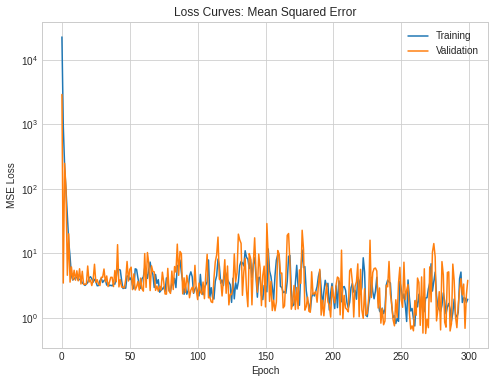

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(metrics.history['loss'], label="Training")
plt.plot(metrics.history['val_loss'], label="Validation")
plt.title("Loss Curves: Mean Squared Error")
plt.legend()
plt.yscale("log")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.show()

Evaluation metrics

In [23]:
def ts_metrics(actual, forecast, return_dict=False):
    mse = mean_squared_error(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    if not return_dict:
        print(f"MSE: {mse:.5}\nMAPE: {mape:.3%}\nMAE: {mae:.5}")
    else:
        return {
            'mse':mse,
            'mape':mape,
            'mae':mae
        }

In [24]:
train_predictions = model.predict(train_X).squeeze()

ts_metrics(train_y, train_predictions)

MSE: 2.2555
MAPE: 0.359%
MAE: 1.2426


Validation goodness-of-fit

In [25]:
valid_predictions = model.predict(valid_X).squeeze()

ts_metrics(valid_y, valid_predictions)

MSE: 3.8162
MAPE: 0.457%
MAE: 1.7542


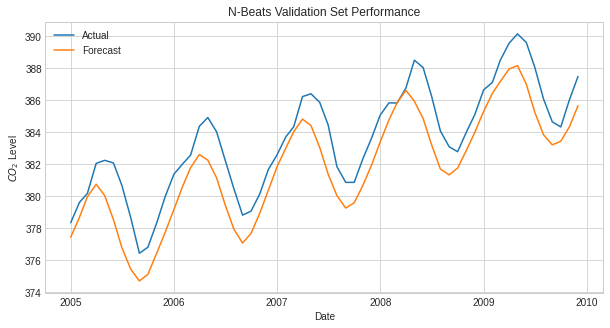

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(valid.index, valid_y, label="Actual")
plt.plot(valid.index, valid_predictions, label="Forecast")
plt.title("N-Beats Validation Set Performance")
plt.legend()
plt.ylabel("$CO_2$ Level")
plt.xlabel("Date")
plt.show()

### Interpretability: Viewing Backcasts
The method of interpretability provided by the N-Beats library is through the backcast provided by each "stack" in an interpretable architecture made up of trend and seasonality stacks. 

The `nbeats-keras` module's `predict` method returns a single backcast for the model, rather than the stack-wise backcasts. In our case, this highlights the smoothed trend over the input series. We'll illustrate this for the first few entries in the validation set.

In [27]:
backcasts = model.predict(valid_X[:3, :], return_backcast=True)
forecasts = model.predict(valid_X[:3, :])

backcasts.shape, forecasts.shape

((3, 12, 1), (3, 1, 1))

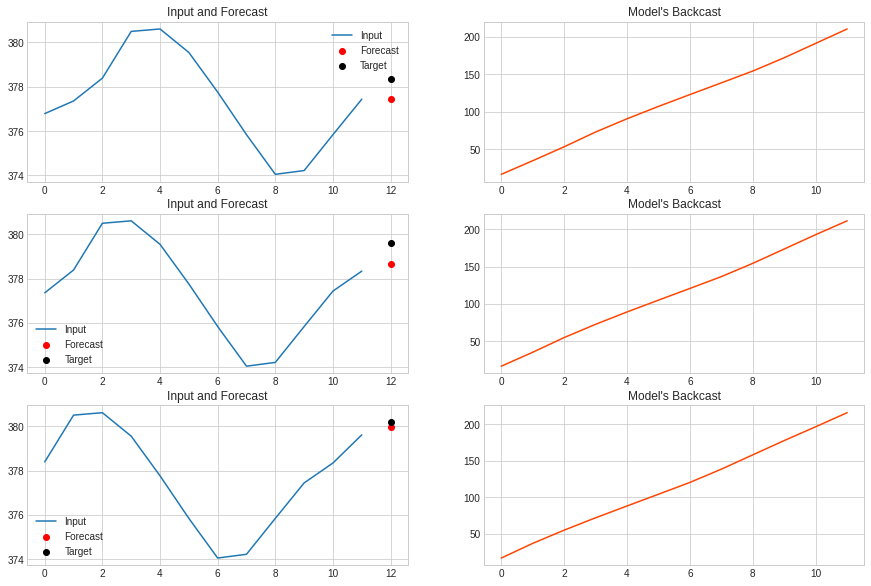

In [28]:
fig, ax = plt.subplots(nrows = forecasts.shape[0], ncols=2, figsize=(15, 10))

for i, ax_ in enumerate(ax):
    ax_[0].plot(range(12), valid_X[i], label = "Input")
    ax_[0].scatter([12], forecasts[i].squeeze(), label="Forecast", color="red")
    ax_[0].scatter([12], valid_y[i], label="Target", color="black")
    ax_[0].set_title("Input and Forecast")
    ax_[0].legend()
    ax_[1].plot(backcasts[i, :].squeeze(), label="Backcast", color="orangered")
    ax_[1].set_title("Model's Backcast")
    
plt.show()

## Evaluate on Test Set
Finally, we can evaluate on the test set.

In [29]:
test_predictions = model.predict(test_X).squeeze()

ts_metrics(test_y, test_predictions)

MSE: 5.6186
MAPE: 0.535%
MAE: 2.1312


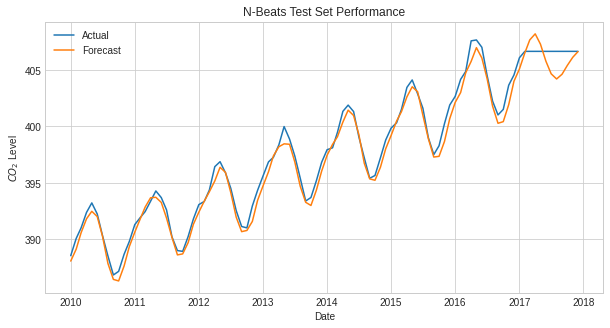

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test_y, label="Actual")
plt.plot(test.index, test_predictions, label="Forecast")
plt.title("N-Beats Test Set Performance")
plt.legend()
plt.ylabel("$CO_2$ Level")
plt.xlabel("Date")
plt.show()